In [1]:
import pandas as pd
import gdown

file_id = "1dUS7nWO7D6MfyVGqD9dfi0rUUMYOpjPS"
url = f"https://drive.google.com/uc?id={file_id}"
file_extension = "downloaded_file.csv"
gdown.download(url, file_extension, quiet=False)
new_df = pd.read_csv(file_extension, sep=";", on_bad_lines='skip')

Downloading...
From (original): https://drive.google.com/uc?id=1dUS7nWO7D6MfyVGqD9dfi0rUUMYOpjPS
From (redirected): https://drive.google.com/uc?id=1dUS7nWO7D6MfyVGqD9dfi0rUUMYOpjPS&confirm=t&uuid=a73eea8b-1fdc-40f2-94a5-e5e08e5ba0b0
To: C:\Users\KW\PycharmProjects\2024-mgr-sluzba-cywilna\Python\Code\downloaded_file.csv
100%|██████████| 275M/275M [02:13<00:00, 2.06MB/s] 


In [2]:
# Correcting a typo.
new_df.rename(columns={"date_annouced": "date_announced"}, inplace=True)

# Converting required level of educations to hierarchical categorical variables:
# 1 - high school education
# 2 - specific profile of high school education
# 3 - higher education
# 4 - specific profile of higher education
# There are no ads that would require less than high school education.
for index, row in new_df.iterrows():
        if row["education"][0:7] == "średnie":
            if len(row["education"]) > 10:
                new_df.at[index, "education"] = 1
            else:
                new_df.at[index, "education"] = 2
        elif row["education"][0:6] == "wyższe":
            if len(row["education"]) > 9:
                new_df.at[index, "education"] = 3
            else:
                new_df.at[index, "education"] = 4


# Unifying the work_time column - the values there, representing a part of the full-time job, have been entered in various formats - e.g. 0.5 and 1/2.
# new_df.loc[:, 'work_time'].unique()
from fractions import Fraction

# Lines necessary for the code below it.
full_time_in_string_df = new_df[new_df['work_time'].str.contains(r'pełen|pełny|1|cały', na=False)]
full_time_in_string_indexes = list(full_time_in_string_df.index)
part_time_in_string_df = new_df[new_df['work_time'].str.contains(r'etatu|lub', na=False)]
part_time_in_string_indexes = list(part_time_in_string_df.index)

# Cleansing the work_time column.
for index, row in new_df.iterrows():
    try:
        new_df.loc[index, 'work_time'] = float(new_df.loc[index, 'work_time'])
    except ValueError:
        try:
            new_df.loc[index, 'work_time'] = float(Fraction(new_df.loc[index, 'work_time']))
        except ValueError:
            try:
                new_df.loc[index, 'work_time'] = float(new_df.loc[index, 'work_time'].replace(',', '.'))
            except ValueError:
                if new_df.loc[index, 'work_time'][9:13] == "0,75":
                    new_df.loc[index, 'work_time'] = 0.75
                elif index in full_time_in_string_indexes:
                    new_df.loc[index, 'work_time'] = 1.0
                elif index in part_time_in_string_indexes:
                    try:
                        new_df.loc[index, 'work_time'] = float(new_df.loc[index, 'work_time'][0:4].replace(',','.'))
                    except ValueError:
                        try:
                            new_df.loc[index, 'work_time'] = float(Fraction(new_df.loc[index, 'work_time'][0:3]))
                        except ValueError:
                            print(new_df.loc[index, 'work_time'])
                elif new_df.loc[index, 'work_time'] == '¼':
                    new_df.loc[index, 'work_time'] = 0.25
                elif new_df.loc[index, 'work_time'] == '3/ 4':
                    new_df.loc[index, 'work_time'] = 0.75
                elif new_df.loc[index, 'work_time'] == '2x0,5':
                    new_df.loc[index, 'work_time'] = 0.5
                # Assuming that more than 1.6 * full-time job is too much to be true.
                elif new_df.loc[index, 'work_time'] == "zastępstwo" or new_df.loc[index, 'work_time'] >= 1.6 or new_df.loc[index, 'work_time'] <= 0.01:
                    new_df.loc[index, 'work_time'] = None


# Filtering out ads with "recruitment canceled" without a reason given.
result2_new_df = new_df.loc[(new_df['result1'] == 'anulowano nabór') & (~new_df["result2"].isna())]
no_reason_cancel_df = new_df.loc[(new_df['result1'] == 'anulowano nabór') & (new_df["result2"].isna())]

# Converting a column to lower case.
result2_new_df.loc[:, ['result2']] = result2_new_df['result2'].str.lower()

# Determining the reason for the cancellation (in the case of only "anulowano nabór" present in result1)
# and assigning records to a corresponding dataframe, depending on if it's a failure or an error.
result2_new_df_error = result2_new_df[result2_new_df['result2'].str.contains(
    r'łędu|łąd|łędem|łędne|orekta ogłoszenia|łędnie|łędny|łędy w ogłoszeniu|rak informacji|ie uwzględniono|łędna|omyłkowo|omyłka|nie uwwzględniono|przypadkowo|dwukrotnie|podwójnie|razy wprowadzono te same|zdublowane|problem techniczny|miana treści|wymaga korekty|nie zawierało wszystkich|korekta|rak informacji|w wymaganiach|błędy|błędnie'
)][['result2']]

# The reason for leaving out first letters of w ords in some cases is that there are cases with such typos.
result2_new_df_failure = result2_new_df[result2_new_df['result2'].str.contains(
    r'bez wyboru kandydatki/kandydata|nie wybrano|nie zatrudniono|rak aplikacji|rak zgłoszeń|rak ofert|rak kandydatów|rak zapisów|rak zapisu kandydatów|kandydaci zrezygnowali|ikt się nie zgłosił|rak kandydatur|rak wniosków|bez zatrudnienia|kandydat zrezygnował|nie spełniały wymagań|nie wyłoniono|rezygnacji kandydata|rezygnacja|kandydat zrezygnował|zrezygnował z|nie zgłosił się|andydaci nie przybyli|zrezygnowali|braku kandydatur|kandydatka zrezygnowała|ezygnacja kandydatki|żadna oferta|rak złożonych ofert|ezygnacja kandydata|nadesłanych ofert|braku kandydatów|braku kandydatur|adna aplikacja|adnej oferty|0 ofert|brak kandydatek|raku kandydatur|rak zgłoszeń|nie zgłosił|rezygnacja|zrezygnował|ie zgłosili się|Liczba kandydatów 2, w tym 1 oferta - nie spełnia niezbędnych wymagań, 1 oferta - wycofana w trakcie trwania naboru|bark zgłoszeń|brak kandydata|braku ofert')
][['result2']]

# Applying same steps to the rest of the records.
new_df.loc[:, ['result1']] = new_df['result1'].str.lower()
rest_new_df_error = new_df[new_df['result1'].str.contains(
    r'łędu|łąd|łędem|łędne|orekta ogłoszenia|łędnie|łędny|łędy w ogłoszeniu|rak informacji|ie uwzględniono|łędna|omyłkowo|omyłka|omyłką|mylnie|nie uwwzględniono|nie uwzględniono|przypadkowo|dwukrotnie|podwójnie|razy wprowadzono te same|zdublowane|problem techniczny|miana treści|wymaga korekty|nie zawierało wszystkich|korekta|rak informacji|w wymaganiach|błędy|błędnie')
][['result1']]
rest_new_df_failure = new_df[new_df['result1'].str.contains(
    r'bez wyboru kandydatki/kandydata|nie wybrano|nie zatrudniono|rak aplikacji|rak zgłoszeń|rak ofert|rak kandydatów|rak zapisów|rak zapisu kandydatów|kandydaci zrezygnowali|ikt się nie zgłosił|rak kandydatur|rak wniosków|bez zatrudnienia|kandydat zrezygnował|nie spełniały wymagań|nie wyłoniono|rezygnacji kandydata|rezygnacja|kandydat zrezygnował|zrezygnował z|nie zgłosił się|andydaci nie przybyli|zrezygnowali|braku kandydatur|kandydatka zrezygnowała|ezygnacja kandydatki|żadna oferta|rak złożonych ofert|ezygnacja kandydata|nadesłanych ofert|braku kandydatów|braku kandydatur|adna aplikacja|adnej oferty|0 ofert|brak kandydatek|raku kandydatur|rak zgłoszeń|nie zgłosił|rezygnacja|zrezygnował|ie zgłosili się|Liczba kandydatów 2, w tym 1 oferta - nie spełnia niezbędnych wymagań, 1 oferta - wycofana w trakcie trwania naboru|bark zgłoszeń|brak kandydata|braku ofert')
][['result1']]

# Ads that ended successfully - a candidate has been employed.
new_df_success = new_df[new_df['result1'].str.contains(
    r'wyborem kandydatki/kandydata|informacja o zatrudnieniu kandydatki|zatrudnieniem|obsadzono stanowisko|wybrano kandydat')
][['result1']]

# Displaying ads that ended up without an assignment.
assigned_ads_indexes = list(new_df_success.index) + list(rest_new_df_error.index) + list(rest_new_df_failure.index) + list(result2_new_df_failure.index) + list(result2_new_df_error.index) + list(no_reason_cancel_df.index)

left_ads_df = new_df[~new_df.index.isin(assigned_ads_indexes)]

# Turns out most of the left ads (1441) are irrelevant for the analysis - canceled for various reasons.
new_df = new_df[~new_df.index.isin(list(left_ads_df.index))]
# Excluding errors too.
cleansed_df = new_df[new_df.index.isin(list(new_df_success.index)+list(rest_new_df_failure.index)+list(result2_new_df_failure.index))]

# Assigning 1 for ads that led to employment, and 0 where there was no success.
cleansed_df.loc[list(new_df_success.index), 'result1'] = 1
cleansed_df.loc[list(result2_new_df_failure.index)+list(rest_new_df_failure.index), 'result1'] = 0

In [3]:
# ASSIGNING POSITION LEVEL CATEGORIES

# Splitting job positions into categories, just like it's been done with 'failure' and 'success'.
# Source for keywords:
# https://sip.lex.pl/akty-prawne/dzu-dziennik-ustaw/okreslenie-stanowisk-urzedniczych-wymaganych-kwalifikacji-zawodowych-18275583

# Should be overwritten by specjalistyczne.
samodzielne_df = cleansed_df[cleansed_df['job_title'].str.contains(
    r'radca|specjalista ruchu drogowego|główny specjalista|konsultant|ekspert skarbowy|oskarżyciel skarbowy|inspektor kontroli wojskowej|nadinspektor zakładów|starszy inspektor transportu|starszy ekspert oceniający|starszy inspektor|zastępca głównego inspektora|starszy oficer portu|główny operator służby kontroli ruchu statków|starszy operator służby kontroli ruchu statków|starszy pilot lotnictwa|starszy oficer portu|starszy inspektor nadzoru nad żeglugą|kustosz|główny metrolog|starszy inspektor farmaceutyczny|starszy inspektor transportu kolejowego|starszy specjalista ruchu drogowego|starszy programista|starszy informatyk|główny informatyk|starszy kontroler weterynaryjny|informatyk wojewódzki|kierownik kancelarii tajnej|audytor wewnętrzny|administrator systemu|inspektor wojewódzki|główny programista|wojewódzki inspektor|starszy metrolog', case=False)][['job_title']]

specjalistyczne_df = cleansed_df[cleansed_df['job_title'].str.contains(r'starszy projektant|starszy archiwista|starszy analityk|specjalista|referendarz|programista|projektant|analityk|psycholog|wizytator|samodzielny księgowy|starszy statystyk|starszy rewident|starszy referent|starszy księgowy|starszy inspektor|oficer portu|inspektor weterynaryjny|asystent laboratoryjny|kontroler skarbowy|kontroler rozliczeń|inspektor transportu kolejowego|pilot lotnictwa|kierownik grupy|starszy bosman|inspektor nadzoru nad żeglugą|aprobant|starszy asystent|młodszy asystent|metrolog|inspektor ruchu drogowego|inspektor transportu drogowego|dokumentalista|konserwator archiwalny|inspektor farmaceutyczny|inspektor ochrony zabytków|inspektor transportu kolejowego|referent prawny|starszy kontroler|starszy poborca|kontroler transportu|kierownik obwodu|kierownik grupy|operator służby kontroli ruchu statków|ekspert|kontroler|starszy nadzorca ochrony wybrzeża', case=False)][['job_title']]

wyzsze_df = cleansed_df[cleansed_df['job_title'].str.contains(r'dyrektor generalny|dyrektor deparatmanetu|dyrektor wydziału|zastępca dyrektora wydziału|zastępca dyrektora|wojewódzki lekarz|powiatowy lekarz|wojewódzkiego lekarza|powiatowego lekarza|zastępca naczelnika urzędu|dyrektor', case=False)][['job_title']]

# Should be overwritten by wyzsze_df.
sredni_szczebel_zarzadzania_df = cleansed_df[cleansed_df['job_title'].str.contains(r'dyrektor oddziału|główny księgowy|zastępca głównego księgowego|zastępca dyrektora oddziału|naczelnik delegatury|kapitan|kapitana|kierownik delegatury|samodzielnego laboratorium|dyrektor wydziału| zastępca dyrektora wydziału|dyrektor delegatury|zastępca dyrektora delegatury|graniczny lekarz weterynarii|zastępca granicznego lekarza weterynarii|zastępca kierownika laboratorium|zastępca wojewódzkiego inspektora nadzoru budowlanego|zastępca powiatowego inspektora nadzoru budowlanego', case=False)][['job_title']]

# This one definitely should be overwritten by all the other conditions due to problematic regex patterns.
wspomagajace_df = cleansed_df[cleansed_df['job_title'].str.contains(r'statystyk|rewident|referent|podreferendarz|młodszy inspektor|asystent|archiwista|młodszy programista|młodszy archiwista|młodszy analityk|sekretarz|technik|drogomistrz|laborant|poborca podatkowy|bosman portu|fotograf|archiwista|księgowy|młodszy programista|informatyk|podreferendarz|kontroler weterynaryjny|młodszy dokumentalista|młodszy konserwator|legalizator|aplikant|poborca skarbowy|inspektor|nadzorca ochrony wybrzeża', case=False)][['job_title']]

# Should be overwritten by sredni_szczebel and wyzsze_df.
koordynujace_df = cleansed_df[cleansed_df['job_title'].str.contains(r'szef oddziału|szef wydizału|koordynator|naczelnik wydziału|zastępca naczelnika wydziału|kierownik zespołu|zastępca kierownika zespołu|pełnomocnik|pełnomocnika|kierownik projektu|kierownik rejonu|kierownik laboratorium|główny inspektor|kierownik oddziału|kierownik wydziału|kierownik działu|kierownik laboratorium|naczelnik|kierownik projektu|kierownik rejonu|kierownika rejonu|zastępca kierownika oddziału|kierownik referatu|kierownik służby liniowej|kierownik sekcji|kierownik pracowni|zastępca kierownika wydziału|kierownik zakładu higieny|kierownik pracowni', case=False)][['job_title']]

# Categorizing ads that ended up without an assignment to the previous categories
position_categories_indexes = (
        list(samodzielne_df.index) + list(specjalistyczne_df.index) + list(wyzsze_df.index) + list(sredni_szczebel_zarzadzania_df.index) +
        list(wspomagajace_df.index) + list(koordynujace_df.index)
)

other_df = cleansed_df[~cleansed_df.index.isin(position_categories_indexes)]

# Assigning cleansed categories to a new column - specific categories might turn out useful later on,
# so I don't want to dispose of this information.

# Creating a new column by copying the existing one.
# The sequence here matters.
cleansed_df["job_position_category"] = cleansed_df["job_title"]
# Changing the values of the column so that it represents job level categories.
cleansed_df.loc[list(wspomagajace_df.index), 'job_position_category'] = 'stanowiska wspomagające'
cleansed_df.loc[list(specjalistyczne_df.index), 'job_position_category'] = 'stanowiska specjalistyczne'
cleansed_df.loc[list(samodzielne_df.index), 'job_position_category'] = 'stanowiska samodzielne'
cleansed_df.loc[list(koordynujace_df.index), 'job_position_category'] = 'stanowiska koordynujące'
cleansed_df.loc[list(sredni_szczebel_zarzadzania_df.index), 'job_position_category'] = 'średni szczebel zarządzania'
cleansed_df.loc[list(wyzsze_df.index), 'job_position_category'] = 'wyższe stanowiska'
cleansed_df.loc[list(other_df.index), 'job_position_category'] = 'other'

C:\Users\KW\AppData\Local\Temp\ipykernel_17032\1947970869.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleansed_df["job_position_category"] = cleansed_df["job_title"]


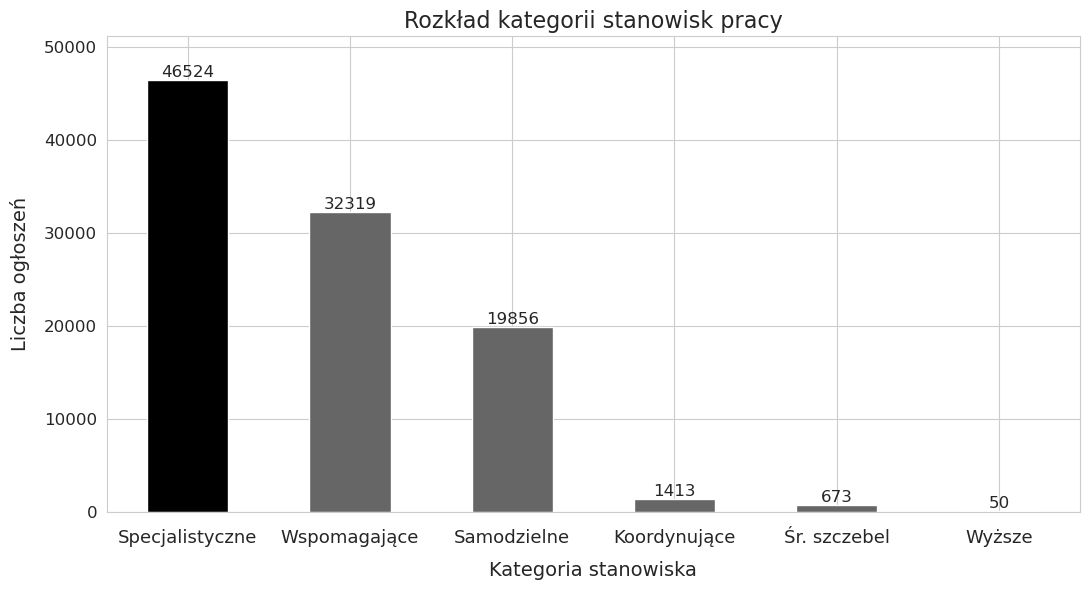

In [4]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 13,
    'ytick.labelsize': 12,
})

plt.figure(figsize=(11, 6))

# Count job positions excluding 'other'
counts = cleansed_df.loc[
    cleansed_df['job_position_category'] != 'other', 'job_position_category'
].value_counts()

colors = ['#000000'] + ['#666666'] * (len(counts) - 1)
ax = counts.plot(kind='bar', color=colors)
plt.xlabel('Kategoria stanowiska', labelpad=10)
plt.ylabel('Liczba ogłoszeń', labelpad=10)
plt.title('Rozkład kategorii stanowisk pracy')

new_labels = ['Specjalistyczne', 'Wspomagające', 'Samodzielne',
              'Koordynujące', "Śr. szczebel", "Wyższe"]
ax.set_xticklabels(new_labels, rotation=0, ha='center')
ax.tick_params(axis='x', pad=9)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=12)

ax.set_ylim(0, counts.max() * 1.10)
plt.tight_layout()
# export
plt.savefig("position_category_bar_chart.png", format="png", bbox_inches="tight")
plt.show()

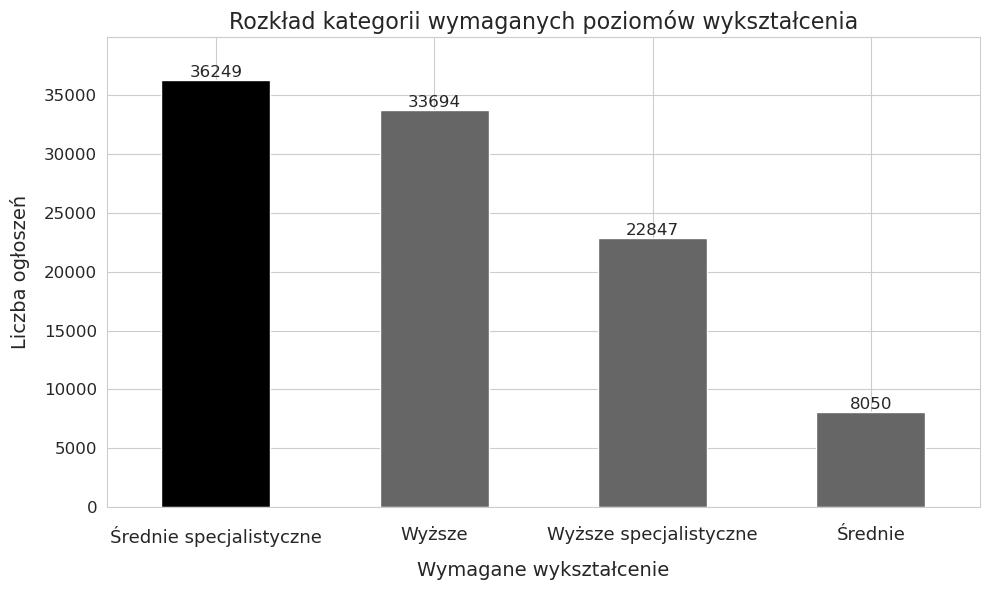

In [5]:
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 13,
    'ytick.labelsize': 12,
})

plt.figure(figsize=(10, 6))
counts = cleansed_df['education'].value_counts()
colors = ['#000000'] + ['#666666'] * (len(counts) - 1)
ax = counts.plot(kind='bar', color=colors)

plt.xlabel('Wymagane wykształcenie', labelpad=10)
plt.ylabel('Liczba ogłoszeń', labelpad=10)
plt.title('Rozkład kategorii wymaganych poziomów wykształcenia')

new_labels = ['Średnie specjalistyczne', 'Wyższe', 'Wyższe specjalistyczne', 'Średnie']
ax.set_xticklabels(new_labels, rotation=0, ha='center')
ax.tick_params(axis='x', pad=10)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=12)

# Adding headroom above bars.
ax.set_ylim(0, counts.max() * 1.10)

plt.tight_layout()
# export
plt.savefig("education_level_bar_chart.png", format="png", bbox_inches="tight")
plt.show()

In [6]:
# Dropping positions that I couldn't determine a category for.
cleansed_df = cleansed_df[~cleansed_df['job_title'].isin(['dezynfektor', 'starszy instruktor'])]

In [7]:
# DETERMINING THE FIELD OF THE JOB

vet_df = (
    cleansed_df[
        cleansed_df['job_title'].str.contains('weteryn.+', regex=True, case=False)
    ]
[['job_title']]
)
IT_n_maths_df = (
    cleansed_df[
        cleansed_df['job_title'].str.contains('.nformaty.+|IT|program.+|statyst.+|matemat.+|anali.+', regex=True, case=True)
    ]
    [['job_title']]
)
# Note: 'veterinary inspector' or 'pharmacy inspector' are categorized as 'vet' and 'pharmacy/chemistry', respectively.
law_df = (
    cleansed_df[
        (cleansed_df['job_title'].str.contains(
            'radca|prawnik|kontroler|skarb.+|prawny|wizytator|aplikant|oskarżyciel|aplikant|referendarz|podreferendarz|księgow.+|inspektor',
            regex=True, case=False)==True) &
        (cleansed_df['job_title'].str.contains('weteryn.+|farmac.+|aptek.+|lecznic.+|laborator.+', regex=True, case=False)==False)
    ]
    [['job_title']]
)
pharmacy_n_chemistry_df = (
    cleansed_df[
        cleansed_df['job_title'].str.contains('farmac.+|aptek.+|lecznic.+|laborator.+', regex=True, case=False)
    ]
    [['job_title']]
)
# Bossman, captain, port, etc.
water_df = (
    cleansed_df[
        cleansed_df['job_title'].str.contains('bossman.+|kapitan|bosman.+|port|wybrzeż.+', regex=True, case=False)
    ]
    [['job_title']]
)
tech_n_construction_df = (
    cleansed_df[
        cleansed_df['job_title'].str.contains('technik|techniczny|górni.+|budowl.+', regex=True, case=False)
    ]
    [['job_title']]
)
documents_df = (
    cleansed_df[
        (cleansed_df['job_title'].str.contains('referent|legalizator|archiwista', case=False)==True) &
        (cleansed_df['job_title'].str.contains('.nformaty.+|IT|program.+|statyst.+|matemat.+|anali.+', regex=True, case=False)==False)
    ]
    [['job_title']]
)
# Manager-like job positions that haven't been categorized in any of the previous fields.
manager_df = (
    cleansed_df[
        (cleansed_df['job_title'].str.contains(r'kierownik|dyrektor|naczelnik.+', regex=True, case=False)==True) &
        (cleansed_df['job_title'].str.contains('weteryn.+|informat.+|port.+|techni.+|górni.+|budowl.+', regex=True, case=False)==False)
    ]
    [['job_title']]
)


# Indices of all obtained matches from the above criteria stored in one list.
job_field_indexes = (
        list(documents_df.index) + list(tech_n_construction_df.index) + list(water_df.index) + list(pharmacy_n_chemistry_df.index) +
        list(manager_df.index) + list(law_df.index) + list(IT_n_maths_df.index) + list(vet_df.index)
)

# Fields that haven't been categorized by the above criteria.
left_job_fields_df = cleansed_df[~cleansed_df.index.isin(job_field_indexes)]


# Most of the fields can be categorized simply by the 'job_title' column, however,
# without including the department name in the 'work_place2' or 'institution' columns,
# around 30% of ads are left without a specific category.

# Browsing through ads that haven't been categorized, to avoid double categorization.
environment_protection_df = (
    left_job_fields_df[
        (cleansed_df['institution'].str.contains('środowisk.+|leśn.+|las.+|roślin.+|nasiennictwa', regex=True, case=False))|
        (cleansed_df['work_place2'].str.contains('środowisk.+|leśn.+|las.+|roślin.+|nasiennictwa', regex=True, case=False))
    ]
)
# Working for the following entities: police, firefighters, military, border guards.
uniformed_services_df = (
    left_job_fields_df[
        (cleansed_df['institution'].str.contains('polic.+|straż.+|wojsk.+|żołnier.+', regex=True, case=False))|
        (cleansed_df['work_place2'].str.contains('polic.+|straż.+|wojsk.+|żołnier.+', regex=True, case=False))
    ]
)
uncategorized_med_df = (
    left_job_fields_df[
        (cleansed_df['institution'].str.contains('med.+|farmaceu.+|chemi.+|sanitar.+', regex=True, case=False))|
        (cleansed_df['work_place2'].str.contains('med.+|farmaceu.+|chemi.+|sanitar.+', regex=True, case=False))
    ]
)
uncategorized_tech_n_construction_df = (
    left_job_fields_df[
        (cleansed_df['institution'].str.contains('budowl.+|górni.+|techn.+|drog.+|dróg|autostrad.+|infrastruk.+', regex=True, case=False))|
        (cleansed_df['work_place2'].str.contains('budowl.+|górni.+|techn.+|drog.+|dróg|autostrad.+|infrastruk.+', regex=True, case=False))
    ]
)
uncategorized_IT_n_statistics_df = (
    left_job_fields_df[
        (cleansed_df['institution'].str.contains('informat.+|architektury danych|statyst.+|analiz.+', regex=True, case=False)==True)|
        (cleansed_df['work_place2'].str.contains('informat.+|architektury danych|statyst.+|analiz.+', regex=True, case=False)==True)&
        (cleansed_df['work_place2'].str.contains('teleinfromatyk.+', regex=True, case=False)==False)
        # ^some jobs at the ICT department are not associated with IT at all.
    ]
)
uncategorized_law_df = (
    left_job_fields_df[
        (cleansed_df['institution'].str.contains('prawn.+|księgow.+', regex=True, case=False))|
        (cleansed_df['work_place2'].str.contains('prawn.+|księgow.+', regex=True, case=False))
    ]
)
uncategorized_water_df = (
    left_job_fields_df[
        (cleansed_df['institution'].str.contains('morsk.+', regex=True, case=False))|
        (cleansed_df['work_place2'].str.contains('morsk.+', regex=True, case=False))
    ]
)
uncategorized_vet_df = (
    left_job_fields_df[
        (cleansed_df['institution'].str.contains('weteryn.+', regex=True, case=False))|
        (cleansed_df['work_place2'].str.contains('weteryn.+', regex=True, case=False))
    ]
)

# Indices of ads that are still left without a category.
# They are going to have 'other' category assigned.
newly_categorized_ads = (
    list(uncategorized_law_df.index) + list(uncategorized_IT_n_statistics_df.index) + list(uncategorized_tech_n_construction_df.index) + list(uncategorized_med_df.index) +
    list(uniformed_services_df.index) + list(uncategorized_law_df.index) + list(environment_protection_df.index) + list(uncategorized_water_df) + list(uncategorized_vet_df.index)
)
other_job_fields_df = left_job_fields_df[~left_job_fields_df.index.isin(newly_categorized_ads)]

# Again, it is undesired to drop the job_title column, so I'm creating a new one.
cleansed_df["job_field"] = cleansed_df["job_title"]
cleansed_df.loc[list(documents_df.index), 'job_field'] = 'documents'
cleansed_df.loc[list(tech_n_construction_df.index), 'job_field'] = 'tech/construction'
cleansed_df.loc[list(uncategorized_tech_n_construction_df.index), 'job_field'] = 'tech/construction'
cleansed_df.loc[list(water_df.index), 'job_field'] = 'water'
cleansed_df.loc[list(uncategorized_water_df.index), 'job_field'] = 'water'
cleansed_df.loc[list(pharmacy_n_chemistry_df.index), 'job_field'] = 'pharmacy/chemistry'
cleansed_df.loc[list(uncategorized_med_df.index), 'job_field'] = 'pharmacy/chemistry'
cleansed_df.loc[list(manager_df.index), 'job_field'] = 'other_manager'
cleansed_df.loc[list(law_df.index), 'job_field'] = 'law'
cleansed_df.loc[list(uncategorized_law_df.index), 'job_field'] = 'law'
cleansed_df.loc[list(IT_n_maths_df.index), 'job_field'] = 'IT/statistics'
cleansed_df.loc[list(uncategorized_IT_n_statistics_df.index), 'job_field'] = 'IT/statistics'
cleansed_df.loc[list(vet_df.index), 'job_field'] = 'vet'
cleansed_df.loc[list(uncategorized_vet_df.index), 'job_field'] = 'vet'
cleansed_df.loc[list(environment_protection_df.index), 'job_field'] = 'environment'
cleansed_df.loc[list(uniformed_services_df.index), 'job_field'] = 'uniformed services'
cleansed_df.loc[list(other_job_fields_df.index), 'job_field'] = 'other'

C:\Users\KW\AppData\Local\Temp\ipykernel_17032\3796436549.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  left_job_fields_df[
C:\Users\KW\AppData\Local\Temp\ipykernel_17032\3796436549.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  left_job_fields_df[
C:\Users\KW\AppData\Local\Temp\ipykernel_17032\3796436549.py:90: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  left_job_fields_df[
C:\Users\KW\AppData\Local\Temp\ipykernel_17032\3796436549.py:96: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  left_job_fields_df[
C:\Users\KW\AppData\Local\Temp\ipykernel_17032\3796436549.py:102: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  left_job_fields_df[
C:\Users\KW\AppData\Local\Temp\ipykernel_17032\3796436549.py:110: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  left_job_fields_df[
C:\Users\KW\AppData\

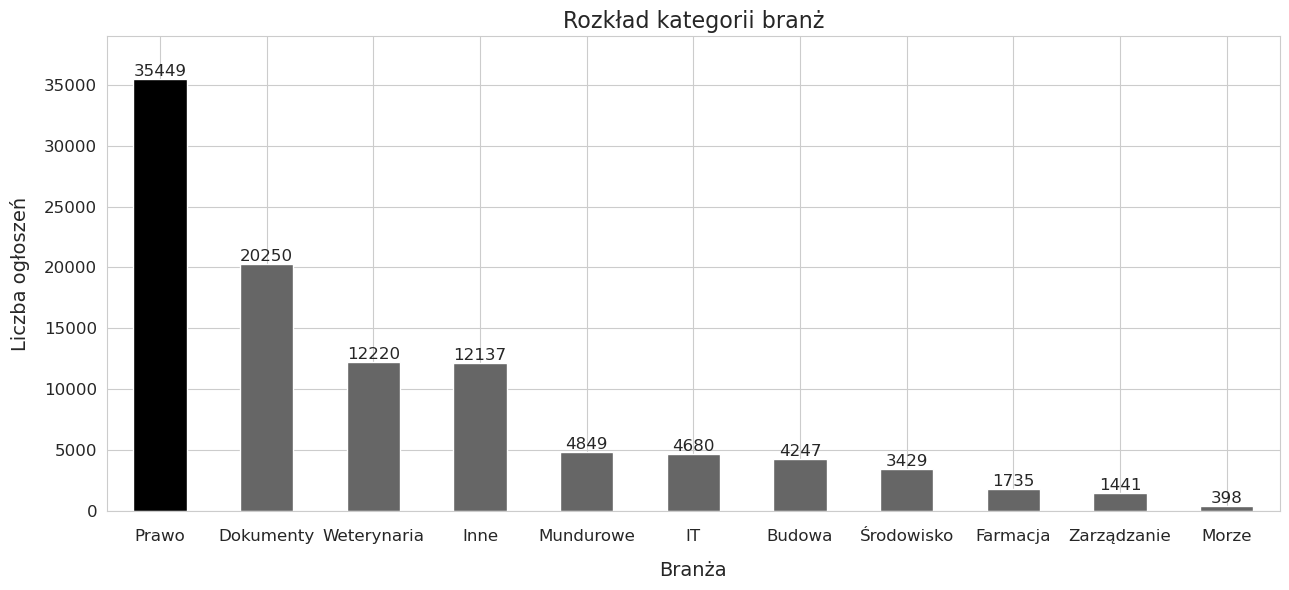

In [8]:
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
})

plt.figure(figsize=(13, 6))
counts = cleansed_df['job_field'].value_counts()

colors = ['#000000'] + ['#666666'] * (len(counts) - 1)
ax = counts.plot(kind='bar', color=colors)
plt.xlabel('Branża', labelpad=12)
plt.ylabel('Liczba ogłoszeń', labelpad=10)
plt.title('Rozkład kategorii branż')

new_labels = ['Prawo', 'Dokumenty', 'Weterynaria', 'Inne', 'Mundurowe',
              'IT', 'Budowa', 'Środowisko',
              'Farmacja', 'Zarządzanie', 'Morze']
ax.set_xticklabels(new_labels, rotation=0, ha='center')
ax.tick_params(axis='x', pad=10)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=12)

ax.set_ylim(0, counts.max() * 1.10)
plt.tight_layout()

# export
plt.savefig("job_field_chart.png", format="png", bbox_inches="tight")
plt.show()

### Formatting

In [9]:
cleansed_df.drop(columns=['result2', 'date_documents', 'date_result', 'date_valid'], inplace=True)

cleansed_df.rename({
    'job_id': 'ad_id',
    'result1': 'result',
    'job_field': 'job_field',
    'job_position_category': 'position_category',
    'job_title': 'position',
    'education': 'education_level',
    'work_time': 'work_time',
    'vacancies': 'vacancies',
    'salary': 'salary',
    'city': 'city',
    'institution': 'institution',
    'address': 'institution_address',
    'work_place1': 'workplace',
    'work_place2': 'department',
    'responsibilities': 'responsibilities',
    'requirements1': 'requirements',
    'requirements2': 'nice_to_have',
    'date_announced': 'date_announced',
    'views': 'views'
}, axis='columns', inplace=True)

desired_order = [
    'ad_id', 'result', 'job_field', 'position_category', 'position',
    'education_level', 'work_time', 'vacancies', 'salary', 'city', 'institution',
    'workplace', 'department', 'institution_address', 'responsibilities',
    'requirements', 'nice_to_have', 'date_announced', 'views'
]
cleansed_df = cleansed_df.loc[:, desired_order]

In [71]:
cleansed_df.to_csv('cleaned_data.csv', index=False)